In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import datacleaner
import datetime
imp.reload(datacleaner)

from datacleaner import *

2023-06-02 18:32:29.828214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 18:32:29.940525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-02 18:32:29.940541: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-02 18:32:30.578539: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
np.random.seed(1)
tf.keras.backend.clear_session()

bd = pd.read_csv(r"training_data.csv")

In [10]:
bd = pd.read_csv(r"training_data.csv")

def tratar_dados(bd):
    bd = ordernar(bd)
    bd = RoadsCleaner(bd)
    #bd = data(bd)
    bd = valores_em_falta(bd)
    bd = eliminar(bd)
    bd = incidentsNumbers(bd)
    bd = luminosidade(bd)
    bd = rainNumbers(bd)
    bd = delayNumbers(bd)
    bd = removeOutlier(bd)
    indice_treino, indice_val=split_data(bd, perc=10)
    escala, bd = data_normalization(bd, norm_range=(-1, 1))
    return bd,indice_treino,indice_val,escala

bd,indice_treino,indice_val,escala=tratar_dados(bd)

/home/sendnuggets/Desktop/Mestrado_MMC/Classificadores e Sistemas Conexionistas/CSC/datacleaner.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd['magnitude_of_delay'][i] = None
/home/sendnuggets/Desktop/Mestrado_MMC/Classificadores e Sistemas Conexionistas/CSC/datacleaner.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd["delay_in_seconds"][count] = valor
/home/sendnuggets/Desktop/Mestrado_MMC/Classificadores e Sistemas Conexionistas/CSC/datacleaner.py:115: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain t

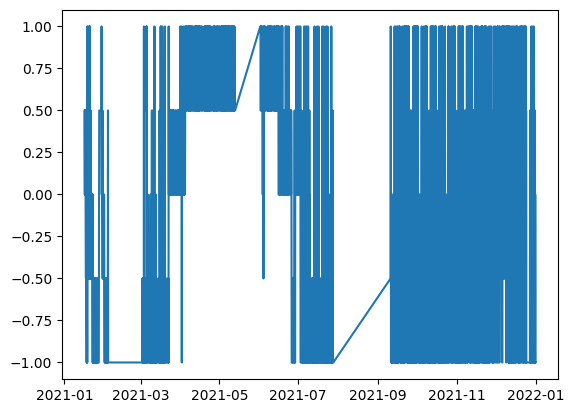

In [4]:
bd.index = pd.to_datetime(bd["record_date"], format="%Y-%m-%d %H:%M:00")
serie(bd,"incidents")
newBd = bd[["incidents","record_date"]]

<Axes: xlabel='record_date'>

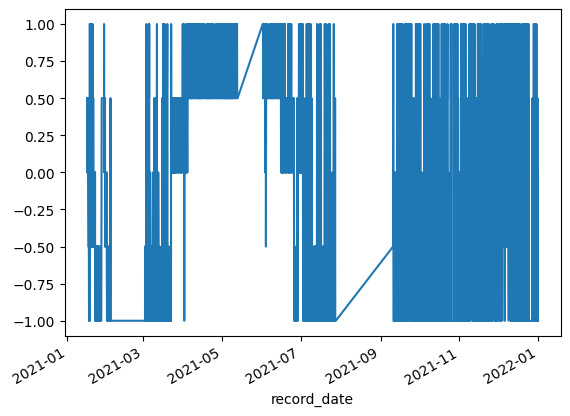

In [5]:
train, test = newBd[0:-600], newBd[-600:]
temp = bd["incidents"]
temp.plot()

In [6]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [15]:
print(temp)
WINDOW_SIZE = 8
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

record_date
2021-01-16 16:00:00    0.5
2021-01-16 18:00:00    0.0
2021-01-16 19:00:00    0.0
2021-01-16 20:00:00    0.0
2021-01-16 21:00:00    0.5
                      ... 
2021-12-31 17:00:00    0.0
2021-12-31 18:00:00   -1.0
2021-12-31 19:00:00   -1.0
2021-12-31 20:00:00   -1.0
2021-12-31 23:00:00   -1.0
Name: incidents, Length: 5000, dtype: float64


((4992, 8, 1), (4992,))

In [8]:
X_train1, y_train1 = X1[:4400], y1[:4400]
X_val1, y_val1 = X1[4400:4800], y1[4400:4800]
X_test1, y_test1 = X1[4800:], y1[4800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4400, 8, 1), (4400,), (400, 8, 1), (400,), (192, 8, 1), (192,))

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=64, input_shape=(1, WINDOW_SIZE), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.Attention(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
model.summary()

2023-06-02 18:32:33.864397: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-02 18:32:33.864438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sendnuggets-VivoBook-ASUSLaptop-X412FL-X412FL): /proc/driver/nvidia/version does not exist
2023-06-02 18:32:33.865837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Input 0 of layer "max_pooling1d" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)